In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings

warnings.filterwarnings("ignore")

In [16]:
df = pd.read_csv(r"D:\OneDrive - greatlakes.edu.in\OFFICE\ML\Datasets\1. pima_indians_diabetes.csv")
print("\nDataset shape:", df.shape)


Dataset shape: (768, 9)


In [19]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [20]:
# COUNT INVALID ZEROS IN EACH FEATURE (PIMA CHECK)

zero_counts = (df == 0).sum()
print("\nNumber of zero values in each feature:\n")
print(zero_counts)



Number of zero values in each feature:

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


In [21]:
# HANDLE INVALID ZEROS (PIMA-SPECIFIC STEP)
invalid_zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[invalid_zero_cols] = df[invalid_zero_cols].replace(0, np.nan)

print("\nMissing values AFTER replacing zeros:\n", df.isnull().sum())


Missing values AFTER replacing zeros:
 Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


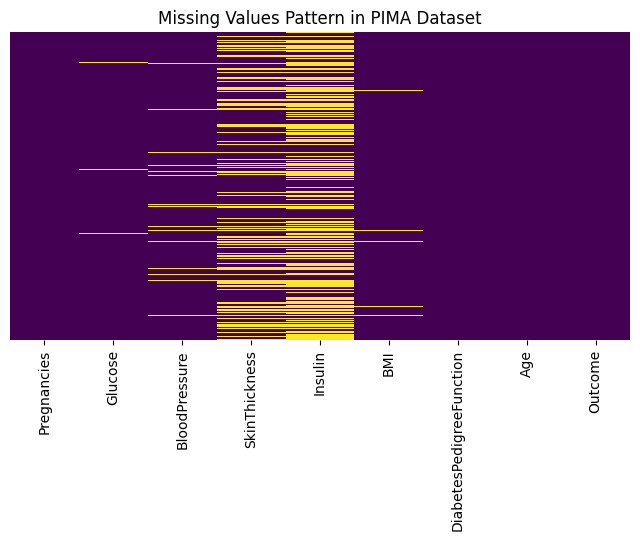

In [22]:
plt.figure(figsize=(8, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Missing Values Pattern in PIMA Dataset")
plt.show()

In [23]:
# SEPARATE FEATURES AND TARGET
X = df.drop("Outcome", axis=1)
y = df["Outcome"]


# TRAIN–TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, stratify=y
)

In [25]:
# IMPUTATION (Proper: fit on train, transform test)
imputer = SimpleImputer(strategy="median")
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed  = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

X_test_imputed.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,8.0,85.0,55.0,20.0,130.0,24.4,0.136,42.0
1,4.0,92.0,80.0,28.0,130.0,42.2,0.237,29.0
2,2.0,99.0,60.0,17.0,160.0,36.6,0.453,21.0
3,4.0,94.0,65.0,22.0,130.0,24.7,0.148,21.0
4,3.0,78.0,50.0,32.0,88.0,31.0,0.248,26.0


# Decision Tree

In [27]:
# DECISION TREE (TRAIN vs TEST)
dt = DecisionTreeClassifier(random_state=10)

dt.fit(X_train_imputed, y_train)

y_pred_train_dt = dt.predict(X_train_imputed)
y_pred_test_dt  = dt.predict(X_test_imputed)

print("\n--- Decision Tree ---")
print("Train Accuracy:", accuracy_score(y_train, y_pred_train_dt))
print("Test Accuracy :", accuracy_score(y_test, y_pred_test_dt))


--- Decision Tree ---
Train Accuracy: 1.0
Test Accuracy : 0.6883116883116883


# K-Fold CV

Decision Tree CV scores: [0.74796748 0.64227642 0.7398374  0.70731707 0.70491803]
Mean CV accuracy: 0.708463281354125


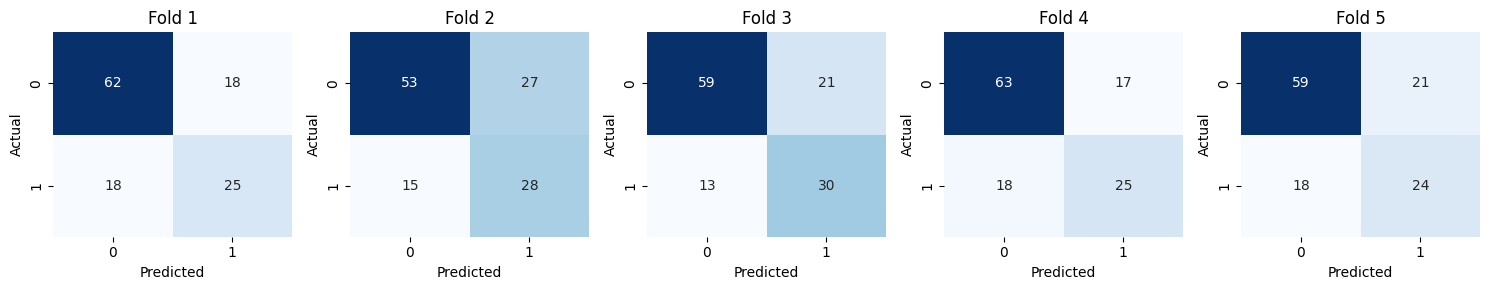

In [28]:
# DECISION TREE — CROSS VALIDATION
cv_scores = cross_val_score(DecisionTreeClassifier(random_state=10), X_train_imputed, y_train, cv=5)
print("Decision Tree CV scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


# STRATIFIED K-FOLD CONFUSION MATRICES
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, (train_idx, test_idx) in enumerate(kf.split(X_train_imputed, y_train)):
    X_tr, X_te = X_train_imputed.iloc[train_idx], X_train_imputed.iloc[test_idx]
    y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]

    dt = DecisionTreeClassifier(random_state=10)
    dt.fit(X_tr, y_tr)
    y_pred = dt.predict(X_te)

    cm = confusion_matrix(y_te, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Bagging or Bootstrap Aggreagation


--- Bagging Classifier ---
Train Accuracy: 0.998371335504886
Test Accuracy : 0.7987012987012987
OOB Score     : 0.750814332247557


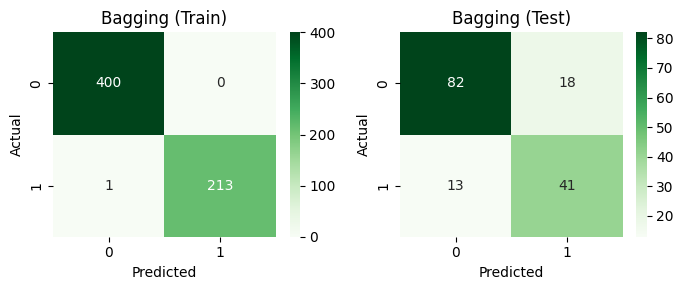

In [29]:

# BAGGING CLASSIFIER
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=10),
    n_estimators=50,
    random_state=10,
    oob_score=True
)

bag.fit(X_train_imputed, y_train)

# Predictions
y_pred_train_bag = bag.predict(X_train_imputed)
y_pred_test_bag  = bag.predict(X_test_imputed)

# Accuracy & OOB
print("\n--- Bagging Classifier ---")
print("Train Accuracy:", accuracy_score(y_train, y_pred_train_bag))
print("Test Accuracy :", accuracy_score(y_test, y_pred_test_bag))
print("OOB Score     :", bag.oob_score_)


# Confusion Matrices (Train vs Test)
fig, axes = plt.subplots(1, 2, figsize=(7,3))

sns.heatmap(confusion_matrix(y_train, y_pred_train_bag), annot=True, fmt="d", cmap="Greens", ax=axes[0])
axes[0].set_title("Bagging (Train)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_pred_test_bag), annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Bagging (Test)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()



--- AdaBoost Classifier ---
Train Accuracy: 0.8403908794788274
Test Accuracy : 0.7727272727272727
OOB Score     : Not available for AdaBoost


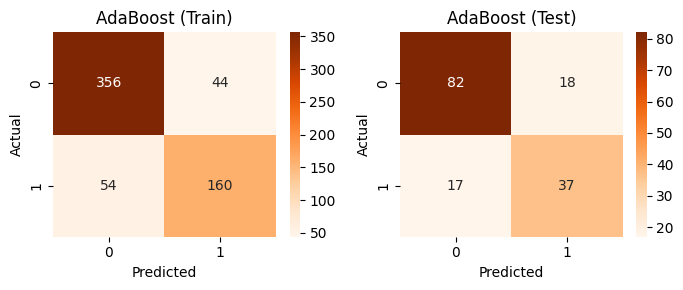

In [30]:
# ADABOOST CLASSIFIER

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=10),
    n_estimators=50,
    random_state=10
)
ada.fit(X_train_imputed, y_train)

# Predictions
y_pred_train_ada = ada.predict(X_train_imputed)
y_pred_test_ada  = ada.predict(X_test_imputed)

# Accuracy
print("\n--- AdaBoost Classifier ---")
print("Train Accuracy:", accuracy_score(y_train, y_pred_train_ada))
print("Test Accuracy :", accuracy_score(y_test, y_pred_test_ada))
print("OOB Score     : Not available for AdaBoost")


# Confusion Matrices (Train vs Test)
fig, axes = plt.subplots(1, 2, figsize=(7,3))

sns.heatmap(confusion_matrix(y_train, y_pred_train_ada), annot=True, fmt="d", cmap="Oranges", ax=axes[0])
axes[0].set_title("AdaBoost (Train)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_pred_test_ada), annot=True, fmt="d", cmap="Oranges", ax=axes[1])
axes[1].set_title("AdaBoost (Test)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


## Bagging: Final Model vs Learning Curve


- The initial Bagging code without a loop is **correct** for training and evaluating the final model:
  - Trains a Bagging ensemble with 50 trees.
  - Computes OOB score.
  - Makes predictions and plots confusion matrices.
- The initial code **does not show how error decreases** as more trees are added.
- To visualize error reduction (learning curve), we use a loop over `n_estimators`:
  - Train models with 1 → N trees.
  - Compute training/test error for each ensemble size.
  - Plot error vs number of trees.
- The loop is **only for visualization/teaching purposes**, not required for correct model training.



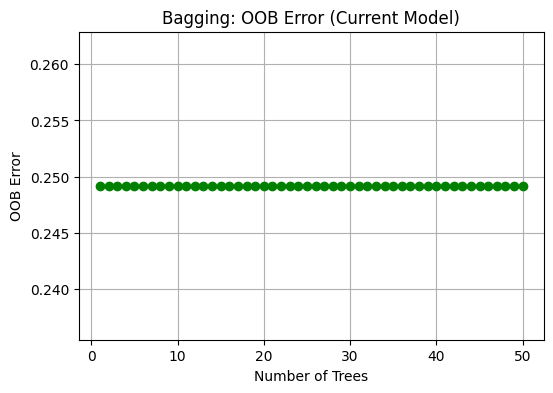

In [31]:

# BAGGING: OOB ERROR PLOT

plt.figure(figsize=(6,4))
plt.plot(range(1, len(bag.estimators_)+1), 
         [1 - bag.oob_score_] * len(bag.estimators_),  # flat line
         marker='o', color='green')
plt.xlabel("Number of Trees")
plt.ylabel("OOB Error")
plt.title("Bagging: OOB Error (Current Model)")
plt.grid(True)
plt.show()

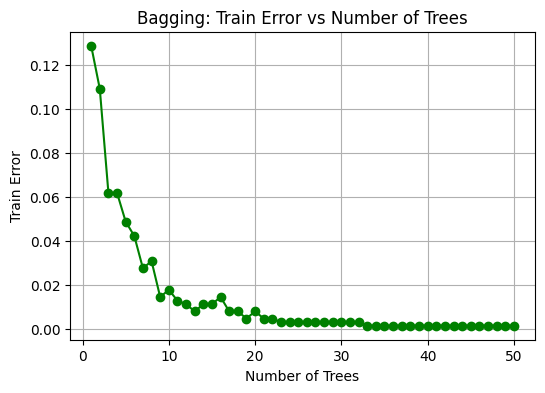

In [33]:
train_errors = []
for n in range(1, 51):
    bag = BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=10),
        n_estimators=n,
        random_state=10,
        bootstrap=True
    )
    bag.fit(X_train_imputed, y_train)
    y_train_pred = bag.predict(X_train_imputed)
    train_errors.append(1 - accuracy_score(y_train, y_train_pred))

plt.figure(figsize=(6,4))
plt.plot(range(1, 51), train_errors, marker='o', color='green')
plt.xlabel("Number of Trees")
plt.ylabel("Train Error")
plt.title("Bagging: Train Error vs Number of Trees")
plt.grid(True)
plt.show()


### AdaBoost: Train/Test Error vs Number of Estimators

- The plot shows **training and test error** as the number of estimators (trees) increases.
- **Training error** (orange line) decreases continuously because AdaBoost keeps fitting the training data better.
- **Test error** (blue line) initially decreases but may **increase after ~20 estimators**, indicating **overfitting**.
- The **optimal number of estimators** is where the test error is lowest — adding more trees beyond this point may worsen generalization.
- Key takeaway: AdaBoost reduces bias but can overfit if too many estimators are used. Monitoring test/validation error is crucial.


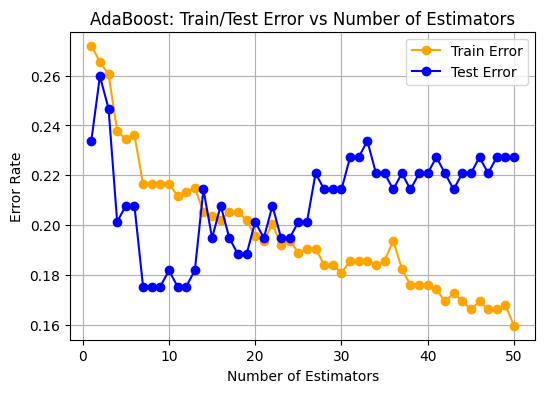

In [34]:
# ADABOOST: TRAIN & TEST ERROR OVER ESTIMATORS
train_errors = []
test_errors = []

for i, y_pred in enumerate(ada.staged_predict(X_train_imputed)):
    train_errors.append(1 - accuracy_score(y_train, y_pred))

for i, y_pred in enumerate(ada.staged_predict(X_test_imputed)):
    test_errors.append(1 - accuracy_score(y_test, y_pred))

plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_errors)+1), train_errors, label='Train Error', marker='o', color='orange')
plt.plot(range(1, len(test_errors)+1), test_errors, label='Test Error', marker='o', color='blue')
plt.xlabel("Number of Estimators")
plt.ylabel("Error Rate")
plt.title("AdaBoost: Train/Test Error vs Number of Estimators")
plt.legend()
plt.grid(True)
plt.show()